In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

## Carregar banco
Carrega o dataframe do ESP recodificado, mas contendo todas as variáveis. No mesmo bloco, selecionamos apenas variáveis de interesse.

In [4]:
# df =  pd.read_parquet("/home/costela/Documentos/Escorpiao-series/Dados_processados/2_df_recodificado.parquet")

df = pd.read_parquet('/home/usuario/Documentos/Escorpiao_series/Dados_processados/2_df_recodificado.parquet')
df = df[(df['DT_SIN_PRI'].dt.year.isin(range(2007, 2019))) & (df['NOME_MUNI']=="SAO PAULO")] # Seleciona o período e municipio
# df = df[['DT_SIN_PRI','NU_AMPOL_9','EVOLUCAO']] Deixar para segundo momento de projeção.

In [3]:
''' Deixar para segundo momento de projeção.

# 1. Substitui a vírgula por ponto
df['NU_AMPOL_9'] = df['NU_AMPOL_9'].str.replace(',', '.')

# 2. Converte para numérico (trata vazios e erros como NaN automaticamente)
df['NU_AMPOL_9'] = pd.to_numeric(df['NU_AMPOL_9'], errors='coerce')

# 3. Se houver NaNs, preencha-os (opcional, aqui com 0)
df['NU_AMPOL_9'] = df['NU_AMPOL_9'].fillna(0)

# 4. Agora converta para inteiro
df['NU_AMPOL_9'] = df['NU_AMPOL_9'].astype(int)
'''

" Deixar para segundo momento de projeção.\n\n# 1. Substitui a vírgula por ponto\ndf['NU_AMPOL_9'] = df['NU_AMPOL_9'].str.replace(',', '.')\n\n# 2. Converte para numérico (trata vazios e erros como NaN automaticamente)\ndf['NU_AMPOL_9'] = pd.to_numeric(df['NU_AMPOL_9'], errors='coerce')\n\n# 3. Se houver NaNs, preencha-os (opcional, aqui com 0)\ndf['NU_AMPOL_9'] = df['NU_AMPOL_9'].fillna(0)\n\n# 4. Agora converta para inteiro\ndf['NU_AMPOL_9'] = df['NU_AMPOL_9'].astype(int)\n"

## Agregar em Time Serie
É preciso transformar em Datetime e Índice, para isso, o pandas precisa que a coluna de data seja reconhecida como o índice do DataFrame. Isso permite que o modelo entenda a sucessão temporal.

Agregação Mensal: Geralmente é a melhor escolha para escorpionismo. Como os acidentes com escorpiões têm um forte componente sazonal (aumentam no calor/chuvas), o ruído dos dados diários pode atrapalhar o modelo. Agregar por mês suaviza anomalias e destaca o ciclo anual.

Agregação Diária: Use apenas se você tiver um volume de dados muito alto e precisar de previsões de curtíssimo prazo (ex: planejar o estoque de soro para amanhã).

Vamos usar a função resample(): 
* O resample funciona como um groupby, mas inteligente para datas. O parâmetro 'MS' significa Month Start (Início do Mês). Ele agrupa todos os dados que caem dentro do mesmo mês (ex: todos os dias de janeiro de 2015) e coloca um "rótulo" no primeiro dia desse mês (2015-01-01).
* O resample sozinho não sabe o que fazer com os dados agrupados. Você precisa dizer a ele como consolidar os valores daquele período. Como você quer o total de casos do mês, usamos o .sum().
* O .to_frame() converte esse resultado de volta para um DataFrame (com colunas e cabeçalho).

O resample garante que a sequência seja contínua. Se houver um mês sem dados no meio do seu arquivo original, o resample vai criar essa linha para você.  
    Atenção: Se o resample criar um mês que não existia antes, ele preencherá o valor como NaN (nulo). Para o ARIMA, você deve transformar esses nulos em zero: df_mes = df_mes.fillna(0)

In [5]:
# Primeiro precisamos agrupar o número de casos por data, para depois agrupar por mês
df = df.groupby('DT_SIN_PRI').size().reset_index(name='CASOS').sort_index()
df.columns = ['DATA','CASOS'] # renomear colunas

In [6]:
# 1. Garante que é datetime
df['DATA'] = pd.to_datetime(df['DATA'])

# 2. Transforma em índice
df.set_index('DATA', inplace=True)

# 3. O CORRETO: Resample na coluna de VALORES (ex: 'casos')
df_mes = df['CASOS'].resample('MS').sum().to_frame()

# 4. Preencher nulos com zero
df_mes = df_mes.fillna(0)

# 5. Garante que o pandas sabe que a frequência é mensal ('MS')
df_mes.index.freq = 'MS'

# 6. Objeto ts para facilitar
ts = df_mes

# 7. Verifica se há valores nulos (ARIMA não aceita NaN)
print(ts.isnull().sum())

CASOS    0
dtype: int64


## Visualizar dados



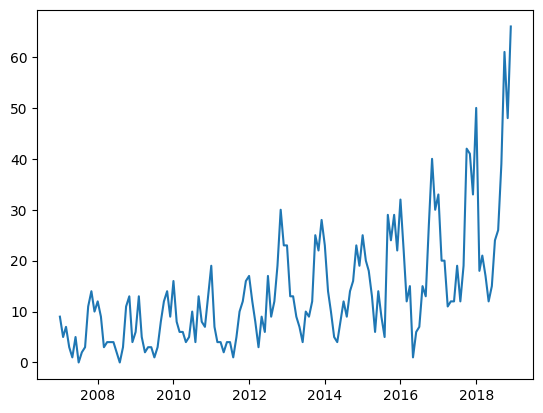

In [7]:
plt.plot(ts)

## Verificar estacionaridade

In [7]:
# Teste adfuller
p_valor_estacionaridade = adfuller(ts.dropna(), autolag="AIC")[1].round(5)

print("ADF p-valor (nível):", 
      p_valor_estacionaridade,
      "\n",
      "(p-valor > 0,05 → evidência de não estacionaridade")


ADF p-valor (nível): 0.53815 
 (p-valor > 0,05 → evidência de não estacionaridade


## Diferenciação (d=1) e checar novamente

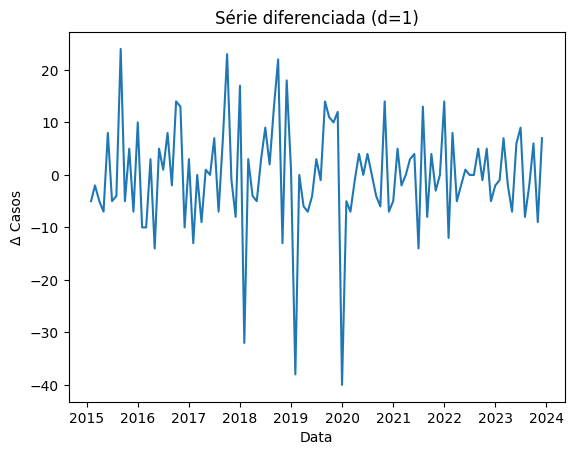

ADF p-valor (nível): 0.0039 
 (p-valor > 0,05 → evidência de não estacionaridade


In [8]:
ts_diff = ts.diff()

plt.figure()
plt.plot(ts_diff)
plt.title("Série diferenciada (d=1)")
plt.xlabel("Data")
plt.ylabel("Δ Casos")
plt.show()

# Teste adfuller
p_valor_estacionaridade = adfuller(ts_diff.dropna(), autolag="AIC")[1].round(5)

print("ADF p-valor (nível):", 
      p_valor_estacionaridade,
      "\n",
      "(p-valor > 0,05 → evidência de não estacionaridade")

# Se ainda fosse não estacionária, você poderia considerar d=2 (raro) ou transformação (log/raiz). Aqui, por didática, seguimos com d=1.


## Verificar autocorrelação (ACF / PACF) na série estacionária

<Figure size 640x480 with 0 Axes>

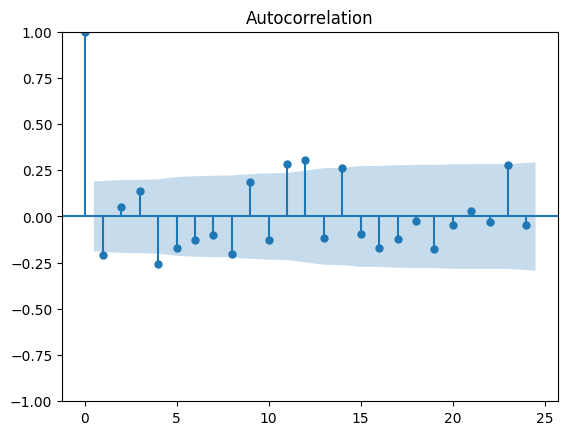

<Figure size 640x480 with 0 Axes>

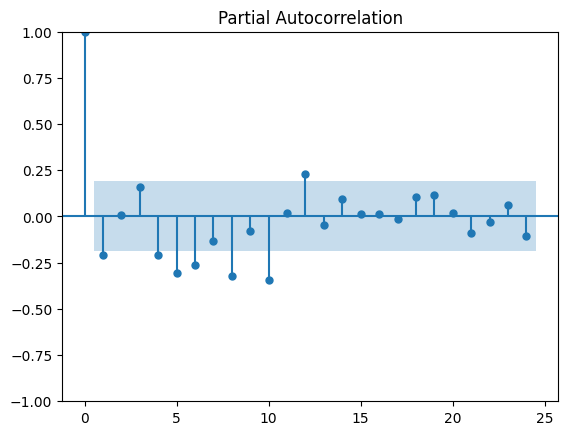

'Leitura\nACF ajuda a sugerir MA(q)\nPACF ajuda a sugerir AR(p)'

In [9]:
plt.figure()
plot_acf(ts_diff.dropna(), lags=24)
plt.show()

plt.figure()
plot_pacf(ts_diff.dropna(), lags=24, method="ywm")
plt.show()

'''Leitura
ACF ajuda a sugerir MA(q)
PACF ajuda a sugerir AR(p)'''

## Ajustar ARIMA automaticamente (sem loop)

Aqui o auto_arima escolhe (p,d,q) minimizando AIC (ou BIC), e já lida com d também (se você preferir deixar automático).

In [10]:
model = pm.auto_arima(
    ts,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    information_criterion="aic"
)

print("Ordem escolhida (p,d,q):", model.order)
print(model.summary())


Ordem escolhida (p,d,q): (1, 0, 4)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 0, 4)   Log Likelihood                -390.357
Date:                Sun, 01 Feb 2026   AIC                            792.715
Time:                        00:06:52   BIC                            808.807
Sample:                    01-01-2015   HQIC                           799.240
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9980      0.006    156.508      0.000       0.986       1.011
ma.L1         -0.4085      0.083     -4.930      0.000      -0.571      -0.246
ma.L2         -0.

## Diagnóstico dos resíduos (ruído branco)
O mais importante é: resíduos sem autocorrelação.

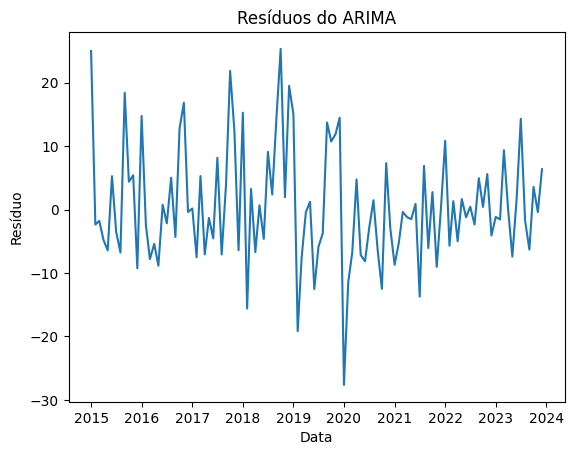

<Figure size 640x480 with 0 Axes>

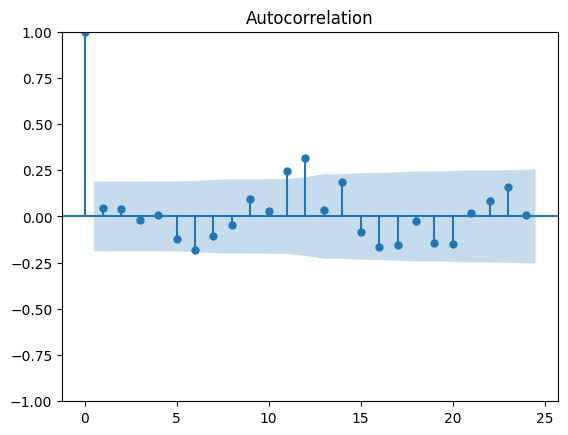

,lb_stat,lb_pvalue
12,28.564295,0.004571
24,51.219286,0.000988


In [ ]:
resid = pd.Series(model.resid(), index=ts.index[-len(model.resid()):])

plt.figure()
plt.plot(resid)
plt.title("Resíduos do ARIMA")
plt.xlabel("Data")
plt.ylabel("Resíduo")
plt.show()

plt.figure()
plot_acf(resid.dropna(), lags=24)
plt.show()

# Ljung-Box: H0 = sem autocorrelação
lb = acorr_ljungbox(resid.dropna(), lags=[12, 24], return_df=True)
lb


'''Interpretação do Ljung-Box
p-valores > 0,05 → ok (resíduos ~ ruído branco)
p-valores < 0,05 → sobrou estrutura temporal (modelo insuficiente)'''

## Projeção de 24 meses e intervalo de confiança

In [12]:
n_periods = 24

fc, ci = model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)

future_idx = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(1), periods=n_periods, freq="MS")
fc = pd.Series(fc, index=future_idx, name="previsao")
ci = pd.DataFrame(ci, index=future_idx, columns=["ic95_inf", "ic95_sup"])


### Plot: observado + previsão + IC

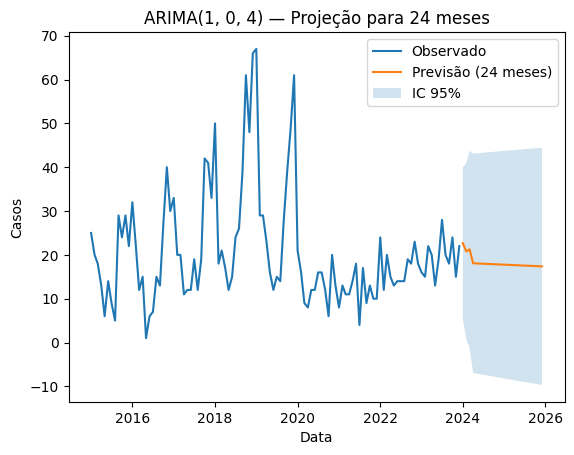

In [13]:
plt.figure()
plt.plot(ts, label="Observado")
plt.plot(fc, label="Previsão (24 meses)")
plt.fill_between(ci.index, ci["ic95_inf"], ci["ic95_sup"], alpha=0.2, label="IC 95%")
plt.title(f"ARIMA{model.order} — Projeção para 24 meses")
plt.xlabel("Data")
plt.ylabel("Casos")
plt.legend()
plt.show()


### Tabela final

In [14]:
out = pd.concat([fc, ci], axis=1)
out.head(12)

,previsao,ic95_inf,ic95_sup
2024-01-01,22.660607,5.326443,39.994772
2024-02-01,20.784348,0.662531,40.906165
2024-03-01,21.267312,-1.226330,43.760953
2024-04-01,18.084092,-6.925469,43.093653
2024-05-01,18.048126,-7.071741,43.167993
2024-06-01,18.012231,-7.217024,43.241487
2024-07-01,17.976408,-7.361332,43.314148
2024-08-01,17.940656,-7.504677,43.385989
2024-09-01,17.904975,-7.647073,43.457023
2024-10-01,17.869365,-7.788534,43.527263
